In [ ]:
import tensorflow as tf

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action='ignore')

## Tensorflow Data API

In [ ]:
# 메모리에서 데이터 생성
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
print(dataset)

dataset = tf.data.Dataset.range(10)
print(dataset)
for item in dataset:
    print(item)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [ ]:
%time
dataset = tf.data.Dataset.range(10)
dataset = dataset.repeat(3).batch(8, drop_remainder=True) # 3번 반복하고 8개씩 묶어서
for item in dataset:
    print(item)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
tf.Tensor([0 1 2 3 4 5 6 7], shape=(8,), dtype=int64)
tf.Tensor([8 9 0 1 2 3 4 5], shape=(8,), dtype=int64)
tf.Tensor([6 7 8 9 0 1 2 3], shape=(8,), dtype=int64)


In [ ]:
dataset = tf.data.Dataset.range(10)

dataset = dataset.map(lambda x : x * 2, num_parallel_calls=2)

for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(18, shape=(), dtype=int64)


In [ ]:
dataset = tf.data.Dataset.range(10)

for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [ ]:
%time
# shuffling
# 0 ~ 29 까지의 숫자를 가지고 텐서를 생성
dataset = tf.data.Dataset.range(30)

#버퍼의 크기는 5로 설정하고 seed는 42로 고정해서 일정하게 배치한 후 6개씩 묶어서 사용
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(6)

for item in dataset:
    print(item)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
tf.Tensor([0 2 3 6 7 9], shape=(6,), dtype=int64)
tf.Tensor([ 4  5 10  1 11  8], shape=(6,), dtype=int64)
tf.Tensor([16 15 14 18 17 21], shape=(6,), dtype=int64)
tf.Tensor([22 23 20 25 24 12], shape=(6,), dtype=int64)
tf.Tensor([27 28 19 29 13 26], shape=(6,), dtype=int64)


In [ ]:
# 데이터를 읽어서 나누어 저장한 후 읽어오기

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
housing = fetch_california_housing()

# train-훈련, valid-훈련 중 검증, test-모델을 훈련한 후 확인
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_mean = scaler.mean_
X_std = scaler.scale_

In [ ]:
print(X_mean, X_std)

[ 3.89175860e+00  2.86245478e+01  5.45593655e+00  1.09963474e+00
  1.42428122e+03  2.95886657e+00  3.56464315e+01 -1.19584363e+02] [1.90927329e+00 1.26409177e+01 2.55038070e+00 4.65460128e-01
 1.09576000e+03 2.36138048e+00 2.13456672e+00 2.00093304e+00]


In [ ]:
# 데이터를 여러 개의 파일로 나누어서 저장하는 함수
# 매개변수는 데이터, 파일의 맨 앞의 공통된 이름, 헤더 포함 여부, 파일의 개수

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):

    # 파일을 저장할 디렉터리 생성
    housing_dir = os.path.join('Datasets', 'housing')
    os.makedirs(housing_dir, exist_ok=True)

    # 파일명 생성
    path_format = os.path.join(housing_dir, 'my_{}_{:02d}.csv')

    filepaths = []
    m = len(data)

    # m 만큼 숫자열을 만든 후 n_parts 개수 만큼 분할해서 만든
    # 그룹 번호는 file_idx에 행 번호는 row_indices에 저장
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):

        # 실제 파일 경로 생성
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)

        # 데이터 기록
        with open(part_csv, 'wt', encoding='utf-8') as f:
            if header is not None:
                f.write(header)
                f.write('\n')
                for row_idx in row_indices:
                    f.write(','.join([repr(col) for col in data[row_idx]]))
                    f.write('\n')

    return filepaths

In [ ]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]

headers_cols = housing.feature_names + ['MedianHouseValue']
header = ','.join(headers_cols)

train_filepaths = save_to_multiple_csv_files(train_data, 'train', header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, 'valid', header, n_parts=20)
test_filepaths = save_to_multiple_csv_files(test_data, 'test', header, n_parts=20)

In [ ]:
# 파일 이름을 랜덤하게 가져오기
filepath_Dataset = tf.data.Dataset.list_files(train_filepaths)
for filepath in filepath_Dataset:
    print(filepath)

tf.Tensor(b'Datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_06.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_18.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_11.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Tensor(b'Datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Ten

In [ ]:
# 5개의 파일에서 번갈아가면서 데이터를 읽어오기
n_readers = 5

# 파일 경로에 있는 내용을 5개씩 번갈아가면서 줄단위로 읽어오기
dataset = filepath_Dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)

for line in dataset.take(5):
    print(line.numpy())

b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'1.6571,34.0,4.454976303317536,1.0876777251184835,1358.0,3.2180094786729856,37.94,-122.35,1.052'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'


In [ ]:
!pip install tensorflow-Datasets

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
Datasets = tfds.load(name='mnist')
mnist_train, mnist_test = Datasets['train'], Datasets['test']

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
datasets = tfds.load(name="smallnorb")

mnist_train, mnist_test = datasets["train"], datasets["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/24300 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/smallnorb/2.0.0.incompleteH52P1C/smallnorb-train.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/24300 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/smallnorb/2.0.0.incompleteH52P1C/smallnorb-test.tfrecord*...:   0%|       …

Dataset smallnorb downloaded and prepared to /root/tensorflow_datasets/smallnorb/2.0.0. Subsequent calls will reuse this data.


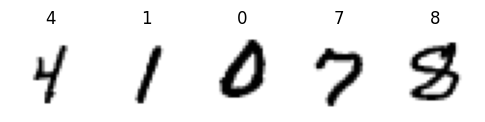

In [ ]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
  images = item["image"]
  labels = item["label"]
  for index in range(5):
    plt.subplot(1, 5, index + 1)
    image = images[index, ..., 0]
    label = labels[index].numpy()
    plt.imshow(image, cmap="binary")
    plt.title(label)
    plt.axis("off")
  break # just showing part of the first batch
